In [54]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch
import numpy as np

model = RobertaForMaskedLM.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [55]:
attention_self_query_weights = []
attention_self_key_weights = []
attention_self_value_weights = []
attention_output_dense_weights = []
intermediate_dense_weights = []
output_dense_weights = []

for i in range(12):
    attention_self_query_weight = model.roberta.encoder.layer[i].attention.self.query.weight
    attention_self_key_weight = model.roberta.encoder.layer[i].attention.self.key.weight
    attention_self_value_weight = model.roberta.encoder.layer[i].attention.self.value.weight
    attention_output_dense_weight = model.roberta.encoder.layer[i].attention.output.dense.weight
    intermediate_dense_weight = model.roberta.encoder.layer[i].intermediate.dense.weight
    output_dense_weight = model.roberta.encoder.layer[i].output.dense.weight
    
    attention_self_query_weights.append(attention_self_query_weight)
    attention_self_key_weights.append(attention_self_key_weight)
    attention_self_value_weights.append(attention_self_value_weight)
    attention_output_dense_weights.append(attention_output_dense_weight)
    intermediate_dense_weights.append(intermediate_dense_weight)
    output_dense_weights.append(output_dense_weight)

attention_self_query_weights= torch.stack(attention_self_query_weights)
attention_self_key_weights = torch.stack(attention_self_key_weights)
attention_self_value_weights = torch.stack(attention_self_value_weights)
attention_output_dense_weights = torch.stack(attention_output_dense_weights)
intermediate_dense_weights = torch.stack(intermediate_dense_weights)
output_dense_weights = torch.stack(output_dense_weights)

stacked_weights = {}
stacked_weights['attention_self_query_weights'] = attention_self_query_weights
stacked_weights['attention_self_key_weights'] = attention_self_key_weights
stacked_weights['attention_self_value_weights'] = attention_self_value_weights
stacked_weights['attention_output_dense_weights'] = attention_output_dense_weights
stacked_weights['intermediate_dense_weights'] = intermediate_dense_weights
stacked_weights['output_dense_weights'] = output_dense_weights

In [56]:
len(stacked_weights)

6

In [57]:
import tensorly as tl
from tensorly.decomposition import parafac

In [58]:
tl.set_backend('pytorch')

In [59]:
from IPython.display import display, clear_output


In [60]:
%matplotlib inline

In [61]:
import matplotlib.pyplot as plt

In [62]:
colors = [
    'red', 'green', 'blue', 'orange', 'purple',
    'cyan', 'magenta', 'yellow', 'black', 'lime',
    'pink', 'brown'
]

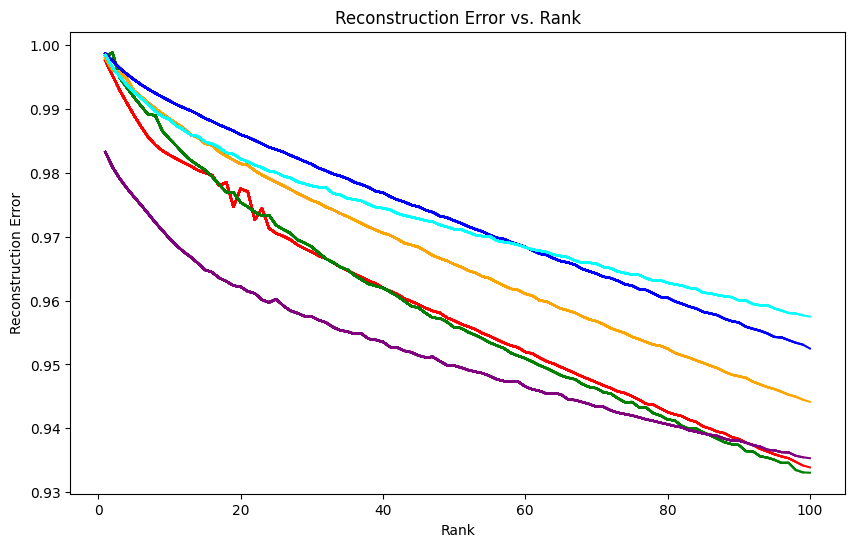

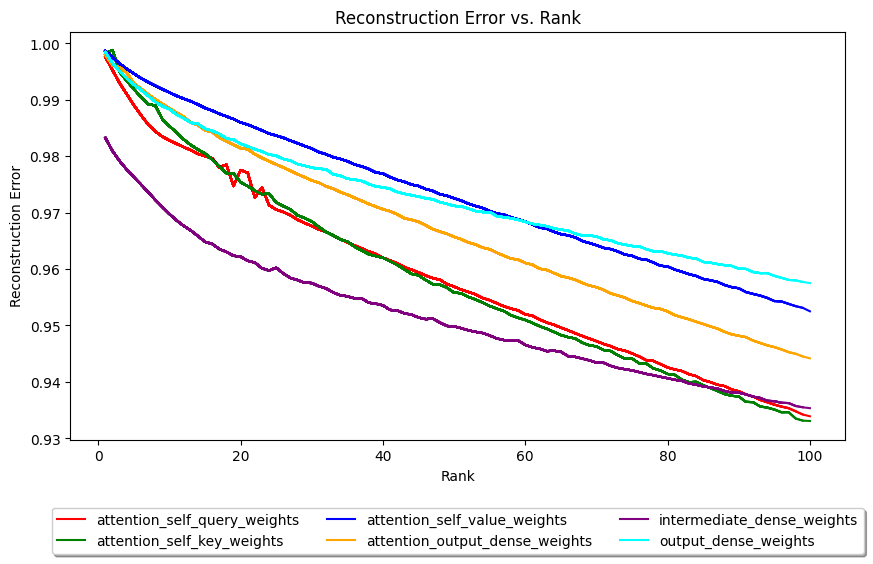

In [63]:
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac
from IPython.display import display, clear_output

reconstruction_error = []

plt.figure(figsize=(10, 6))

# Assuming 'stacked_weights' and 'colors' are defined earlier in your code.
# Ensure 'colors' has enough entries for each item in 'stacked_weights'.

for i, (name, weights) in enumerate(stacked_weights.items()):  # Use enumerate for cleaner code
    errors = []
    for r in range(1, 101):  # Loop through ranks 1 to 100
        tensorly_Tensor = tl.tensor(weights, device='cuda')
        
        # Decompose the tensor using PARAFAC
        factors = parafac(tensorly_Tensor, rank=r, init='random')
        
        # Reconstruct the tensor from its factors
        rec = tl.kruskal_to_tensor(factors)
        
        # Calculate the relative reconstruction error
        error = tl.norm(tensorly_Tensor.cpu() - rec.cpu()) / tl.norm(tensorly_Tensor.cpu())
        errors.append(error)
        
        clear_output(wait=True)
        
        # Plot current errors
        plt.plot(range(1, r+1), errors, color=colors[i], label=name if r == 100 else "_nolegend_")
        plt.xlabel('Rank')
        plt.ylabel('Reconstruction Error')
        plt.title('Reconstruction Error vs. Rank')
        
        # Display the updated plot
        display(plt.gcf())
        
    reconstruction_error.append(errors)

# Adjust plot to make room for legend
plt.subplots_adjust(bottom=0.2)
# Now add the legend outside the loop, assuming all lines are plotted
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=3)

plt.savefig('roberta_reconstruction_error_across_layers.png')
